# Final Project : Classifying Prospects
### Paul Kauffman & Julian Furrow
Attempting to classify potential clients using policy types they underwrite.

# Import Packages 

In [72]:
import pandas as pd
from __future__ import division
import numpy as np 
from nltk.corpus import stopwords
#from plotly.offline import init_notebook_mode, iplot
import nltk
import matplotlib.pyplot as plt
import plotly.graph_objs as go
#import plotly.plotly as py
#from plotly import tools
#import plotly
#plotly.offline.init_notebook_mode(connected=True)

# Accuracy Reference Matrix

In [73]:
#pd.read_excel('C:/Users/paulka/Desktop/Final Project/Model Summary.xlsx')

# Upload Dataset

In [74]:
df = pd.read_excel('C:/Users/Paul/Desktop/Rockhurst/BIA 6304-Text Mining/Final Project/PE Classification Data.xlsx')
df = df.replace('/n', ' ', regex = True)
print(df.shape) # Shape of the dataset
print(list(df))
df.head(10)

(27971, 3)
['ProgramEntityPlusId', 'CoverageTypes', 'ClientClassification']


,ProgramEntityPlusId,CoverageTypes,ClientClassification
0,AISP00036,"GENERAL LIABILITY, LIQUOR LIABILITY",Services
1,AISP00060,"TRUCK LIABILITY, AUTOMOBILE",General
2,AISP00092,"GENERAL LIABILITY, EXCESS LIABILITY",Manufacturing
3,AISP00093,GENERAL LIABILITY,Services
4,AISP00127,"GENERAL LIABILITY, PROPERTY",Retail Trade
5,AISP00128,"EMPLOYMENT PRACTICES LIABILITY, HIRED/NON-OWN...",General
6,AISP00153,"PROFESSIONAL LIABILITY, PROPERTY, PACKAGE",Real Estate
7,AISP00164,"PACKAGE, GEN. LIAB./PROF. LIAB.",General
8,AISP00170,"BUSINESS OWNERS, GEN. LIAB./PROF. LIAB., PROF...",General
9,AISP00241,"EMPLOYMENT PRACTICES LIABILITY, CARGO, PACKAG...",Services


# Count of Client Classification Records

In [75]:
df.groupby('ClientClassification').count()

,ProgramEntityPlusId,CoverageTypes
ClientClassification,,
*Dummy Data,1,1
Agriculture,258,258
Construction,1969,1969
General,7889,7889
Government,49,49
Manufacturing,120,120
Mining,74,74
Real Estate,4445,4445
Retail Trade,839,839


# Import Sklearn Packages

In [76]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import PCA, RandomizedPCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.svm import SVC

# Base CountVectorizor 
    using base vecotrizer to establish baseline models

In [77]:
cv = CountVectorizer(binary=True, lowercase=True, max_df=1.0, max_features=None, 
                     min_df=1, ngram_range=(1,1), stop_words=None)

cv_dm = cv.fit_transform(df['CoverageTypes'].values.astype('U'))
print(cv_dm.shape)
names = cv.get_feature_names()   
count = np.sum(cv_dm.toarray(), axis = 0) 
count2 = count.tolist() 
count_df = pd.DataFrame(count2, index = names, columns = ['count']) 
print(count_df.sort_values(['count'], ascending = False)[0:100] .head())
print(count_df.sort_values(['count'], ascending = False)[0:100] .tail())


(27971, 173)
           count
liability  23355
general    21020
package    17021
property   14328
auto       10453
            count
terrorism     344
operators     331
indemnity     317
protection    317
glass         314


## ---------------------------------------------------------------------------------------------------------------------------------
# [Round 1]
## ---------------------------------------------------------------------------------------------------------------------------------

Base models to see how well the models predict on the test data. Test/Train is at 95/5. 

In [78]:
X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])
print(X.shape)


y = df['ClientClassification'].values #this is an array of labels
#print(type(y), y[0:10])
print(y.shape)

# train and test on count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(27971, 173)
(27971,)
(26572, 173)
(1399, 173)
(26572,)
(1399,)


### Decision Tree
(40%)

In [79]:
# fit a Decision Tree dt_model to the data
dt_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
#print(dt_model)
dt_model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = dt_model.predict(X_test)

#print(dt_model.score(X_test, y_test))

# summarize the fit of the dt_model
print("accuracy: \n" + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print('===================')
print(metrics.classification_report(clf1_expected, clf1_predicted))

accuracy: 
0.4045746962115797
                 precision    recall  f1-score   support

    Agriculture       0.22      0.12      0.16        16
   Construction       0.19      0.14      0.16        94
        General       0.34      0.43      0.38       408
     Government       0.00      0.00      0.00         3
  Manufacturing       0.00      0.00      0.00         5
         Mining       0.00      0.00      0.00         1
    Real Estate       0.40      0.47      0.43       200
   Retail Trade       0.18      0.11      0.14        44
       Services       0.50      0.43      0.46       472
 Transportation       0.58      0.47      0.52       154
Wholesale Trade       0.00      0.00      0.00         2

    avg / total       0.41      0.40      0.40      1399



### Logistic Regression
(51%)

In [80]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = lr_model.predict(X_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.509649749821301
                 precision    recall  f1-score   support

    Agriculture       0.67      0.12      0.21        16
   Construction       0.47      0.07      0.13        94
        General       0.40      0.50      0.44       408
     Government       0.00      0.00      0.00         3
  Manufacturing       0.00      0.00      0.00         5
         Mining       0.00      0.00      0.00         1
    Real Estate       0.58      0.58      0.58       200
   Retail Trade       0.57      0.09      0.16        44
       Services       0.55      0.63      0.59       472
 Transportation       0.67      0.53      0.59       154
Wholesale Trade       0.00      0.00      0.00         2

    avg / total       0.52      0.51      0.49      1399



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Naive Bayes
(44%)

In [81]:
# fit a Naive Bayes model to the data
nb_model = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
#print(nb_model)
nb_model.fit(X_train, y_train)

# make predictions
clf3_expected = y_test
clf3_predicted = nb_model.predict(X_test)

#print(nb_model.score(X_test, y_test))

# summarize the fit of the nb_model
print("accuracy: \n" + str(metrics.accuracy_score(clf3_expected, clf3_predicted)))
print('===================')
print(metrics.classification_report(clf3_expected, clf3_predicted))

accuracy: 
0.44388849177984274
                 precision    recall  f1-score   support

    *Dummy Data       0.00      0.00      0.00         0
    Agriculture       0.30      0.19      0.23        16
   Construction       0.22      0.16      0.19        94
        General       0.35      0.50      0.41       408
     Government       0.00      0.00      0.00         3
  Manufacturing       0.00      0.00      0.00         5
         Mining       0.00      0.00      0.00         1
    Real Estate       0.58      0.48      0.53       200
   Retail Trade       0.29      0.11      0.16        44
       Services       0.54      0.46      0.50       472
 Transportation       0.58      0.51      0.54       154
Wholesale Trade       0.00      0.00      0.00         2

    avg / total       0.46      0.44      0.44      1399



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### Random Forest
(48%)

In [82]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#print(rf_model)

rf_model.fit(X_train, y_train)

clf4_expected = y_test
clf4_predicted = rf_model.predict(X_test)

#print(rf_model.score(X_test,y_test))

# summarize the fit of the rf_model
print("accuracy: \n" + str(metrics.accuracy_score(clf4_expected, clf4_predicted)))
print(metrics.classification_report(clf4_expected, clf4_predicted))

accuracy: 
0.4832022873481058
                 precision    recall  f1-score   support

    Agriculture       0.29      0.12      0.17        16
   Construction       0.34      0.12      0.17        94
        General       0.37      0.43      0.40       408
     Government       0.00      0.00      0.00         3
  Manufacturing       0.00      0.00      0.00         5
         Mining       0.00      0.00      0.00         1
    Real Estate       0.52      0.52      0.52       200
   Retail Trade       0.28      0.11      0.16        44
       Services       0.53      0.63      0.58       472
 Transportation       0.73      0.54      0.62       154
Wholesale Trade       0.00      0.00      0.00         2

    avg / total       0.48      0.48      0.47      1399



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Also Tried 
- SVM (50%)
- Boosting (51%)
- Bagging
- KNN
- NN

Logistic Regression was the best model at 51%. Random forest also showed promise, though LR was the quick to run model. 

## ---------------------------------------------------------------------------------------------------------------------------------
# [Round 2]
## ---------------------------------------------------------------------------------------------------------------------------------

The "General" Classification is a "catch-all" for Agents that had trouble being classified. Genral could be creating noise for the other classe. We may look to use this model to improve on the classification of the "General" population.  

## Removing General to try and improve accuracy 

### New DF without "General" Class

In [83]:
print(df.shape)
df_drop_gen = df[(df.ClientClassification != 'General') & (df.ClientClassification != '*Dummy Data') ]
print(df_drop_gen.shape)

(27971, 3)
(20081, 3)


### Weights Vectorizer
    adding in a weighted set to see if model preform differently 

In [84]:
wv = TfidfVectorizer(binary=False, lowercase=True, max_df=1.0, max_features=None, 
                     min_df=1, ngram_range=(1,1), stop_words=None)


wv_dm = wv.fit_transform(df_drop_gen['CoverageTypes'].values.astype('U'))
print(wv_dm.shape)
wv_df =pd.DataFrame(wv_dm.toarray(), columns=wv.get_feature_names())

(20081, 171)


### Counts Vectorizer 

In [85]:
cv = CountVectorizer(binary=False, lowercase=True, max_df=1.0, max_features=None, 
                     min_df=1, ngram_range=(1,1), stop_words=None)

cv_dm = cv.fit_transform(df_drop_gen['CoverageTypes'].values.astype('U'))
print(cv_dm.shape)
cv_df =pd.DataFrame(cv_dm.toarray(), columns=cv.get_feature_names())

(20081, 171)


### Test/Train Split (Count) (95/5)

In [86]:
X = cv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X), X[0:10])
print(X.shape)


y = df_drop_gen['ClientClassification'].values #this is an array of labels
#print(type(y), y[0:10])
print(y.shape)


# train and test on count
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(20081, 171)
(20081,)
(19076, 171)
(1005, 171)
(19076,)
(1005,)


### Test/Train Split (Weights) (95/5)

In [87]:
X_w = wv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X_w), X_w[0:10])
print(X_w.shape)


y_w = df_drop_gen['ClientClassification'].values #this is an array of labels
#print(type(y_w), y[0:10])
print(y_w.shape)


# train and test on count
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size=0.05, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_w_train.shape)
print(X_w_test.shape)
print(y_w_train.shape)
print(y_w_test.shape)

(20081, 171)
(20081,)
(19076, 171)
(1005, 171)
(19076,)
(1005,)


### Decision Tree (Count) 
(55%)

In [88]:
# fit a Decision Tree dt_model to the data
dt_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
#print(dt_model)
dt_model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = dt_model.predict(X_test)

#print(dt_model.score(X_test, y_test))

# summarize the fit of the dt_model
print("accuracy: \n" + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print('===================')
print(metrics.classification_report(clf1_expected, clf1_predicted))

accuracy: 
0.5572139303482587
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.16      0.15      0.16        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
         Mining       0.00      0.00      0.00         0
    Real Estate       0.55      0.61      0.57       228
   Retail Trade       0.32      0.18      0.23        39
       Services       0.64      0.65      0.65       475
 Transportation       0.68      0.64      0.66       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.55      0.56      0.55      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### Decision Tree (Weight) 
(56%)

In [89]:
# fit a Decision Tree dt_model to the data
dt_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
#print(dt_model)
dt_model.fit(X_w_train, y_w_train)

# make predictions
clf1_expected = y_w_test
clf1_predicted = dt_model.predict(X_w_test)

#print(dt_model.score(X_test, y_test))

# summarize the fit of the dt_model
print("accuracy: \n" + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print('===================')
print(metrics.classification_report(clf1_expected, clf1_predicted))

accuracy: 
0.5611940298507463
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.16      0.13      0.15        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.58      0.58      0.58       228
   Retail Trade       0.27      0.18      0.22        39
       Services       0.63      0.68      0.65       475
 Transportation       0.61      0.64      0.62       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.54      0.56      0.55      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Logistic Regression (Count)
(66%)

In [90]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = lr_model.predict(X_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6626865671641791
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.32      0.09      0.14        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.72      0.67      0.69       228
   Retail Trade       0.40      0.10      0.16        39
       Services       0.64      0.87      0.74       475
 Transportation       0.81      0.64      0.71       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.62      0.66      0.62      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Logistic Regression (Weight)
(65%)

In [91]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_w_train, y_w_train)

# make predictions
clf2_expected = y_w_test
clf2_predicted = lr_model.predict(X_w_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6587064676616915
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.41      0.28      0.33        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.74      0.62      0.67       228
   Retail Trade       0.56      0.13      0.21        39
       Services       0.65      0.84      0.73       475
 Transportation       0.73      0.63      0.67       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.64      0.66      0.63      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Random Forest (Count)
(62%)

In [92]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#print(rf_model)

rf_model.fit(X_train, y_train)

clf4_expected = y_test
clf4_predicted = rf_model.predict(X_test)

#print(rf_model.score(X_test,y_test))

# summarize the fit of the rf_model
print("accuracy: \n" + str(metrics.accuracy_score(clf4_expected, clf4_predicted)))
print(metrics.classification_report(clf4_expected, clf4_predicted))

accuracy: 
0.6238805970149254
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.17      0.08      0.11        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
         Mining       0.00      0.00      0.00         0
    Real Estate       0.67      0.61      0.64       228
   Retail Trade       0.38      0.21      0.27        39
       Services       0.63      0.81      0.71       475
 Transportation       0.72      0.62      0.67       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.59      0.62      0.60      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### Random Forest (Weight)
(64%)

In [93]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#print(rf_model)

rf_model.fit(X_w_train, y_w_train)

clf4_expected = y_w_test
clf4_predicted = rf_model.predict(X_w_test)

#print(rf_model.score(X_test,y_test))

# summarize the fit of the rf_model
print("accuracy: \n" + str(metrics.accuracy_score(clf4_expected, clf4_predicted)))
print(metrics.classification_report(clf4_expected, clf4_predicted))

accuracy: 
0.6407960199004975
                 precision    recall  f1-score   support

    Agriculture       0.50      0.07      0.12        15
   Construction       0.25      0.09      0.13        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
         Mining       0.00      0.00      0.00         0
    Real Estate       0.71      0.63      0.67       228
   Retail Trade       0.44      0.18      0.25        39
       Services       0.63      0.83      0.72       475
 Transportation       0.75      0.63      0.68       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.61      0.64      0.61      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



With the removal of General from the training set all models preformed much better. This is due, more then likely, to the removal of the noise that the General classification created. Logistic regression was still the best model at 66%. DT and RF did show improvement when the weighted tokens were used. 

## ---------------------------------------------------------------------------------------------------------------------------------
# [Round 3]
## ---------------------------------------------------------------------------------------------------------------------------------

### Changes:
- Remove common policy types
- Binary = True
- Tonenizer(x.split(','))
- 80/20 split

* Tonenizer(x.split(','))
#### This will isolate specific policy types by splitting each token between commas. This will help reduce the feature space to see if this helps provie lift

### Count Vectorizer

In [94]:
cv = CountVectorizer(binary=True, lowercase=True, max_df=1.0, max_features=None, 
                     min_df=1, ngram_range=(1,1), tokenizer=lambda x: x.split(','))

cv_dm = cv.fit_transform(df_drop_gen['CoverageTypes'].values.astype('U'))
print(cv_dm.shape)
names = cv.get_feature_names()   
count = np.sum(cv_dm.toarray(), axis = 0) 
count2 = count.tolist() 
count_df = pd.DataFrame(count2, index = names, columns = ['count']) 
#count_df.sort_values(['count'], ascending = False)[0:100] 

(20081, 130)


In [95]:
#count_df.sort_values(['count'], ascending = False)[0:100]

### Weights Vectorizer

In [96]:
wv = TfidfVectorizer(binary=True, lowercase=True, max_df=1.0, max_features=None, 
                     min_df=1, ngram_range=(1,1), tokenizer=lambda x: x.split(','))

wv_dm = wv.fit_transform(df_drop_gen['CoverageTypes'].values.astype('U'))
print(wv_dm.shape)
names = wv.get_feature_names()   
count = np.sum(wv_dm.toarray(), axis = 0) 
count2 = count.tolist() 
count_df = pd.DataFrame(count2, index = names, columns = ['count']) 
#count_df.sort_values(['count'], ascending = False)[0:100] 

(20081, 130)


### Test/Train Split (Counts) (80/20)

In [97]:
X = cv_dm.toarray() 
#print(type(X), X[0:10])
print(X.shape)

y = df_drop_gen['ClientClassification'].values
#print(type(y), y[0:10])
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(20081, 130)
(20081,)
(19076, 130)
(1005, 130)
(19076,)
(1005,)


### Test/Train Split (Weights) (80/20)

In [98]:
X_w = wv_dm.toarray()  #remember this is the output from the vectorizer and we are turning it into an array
#print(type(X_w), X_w[0:10])
print(X_w.shape)


y_w = df_drop_gen['ClientClassification'].values #this is an array of labels
#print(type(y_w), y[0:10])
print(y_w.shape)


# train and test on count
X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y_w, test_size=0.05, random_state=42) #random_state is set seed

# function creates 4 output structures - order matters
print(X_w_train.shape)
print(X_w_test.shape)
print(y_w_train.shape)
print(y_w_test.shape)

(20081, 130)
(20081,)
(19076, 130)
(1005, 130)
(19076,)
(1005,)


### Decision Tree (Count) 
(55%)

In [99]:
# fit a Decision Tree dt_model to the data
dt_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
#print(dt_model)
dt_model.fit(X_train, y_train)

# make predictions
clf1_expected = y_test
clf1_predicted = dt_model.predict(X_test)

#print(dt_model.score(X_test, y_test))

# summarize the fit of the dt_model
print("accuracy: \n" + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print('===================')
print(metrics.classification_report(clf1_expected, clf1_predicted))

accuracy: 
0.5492537313432836
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.16      0.16      0.16        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.57      0.60      0.59       228
   Retail Trade       0.24      0.18      0.21        39
       Services       0.64      0.65      0.65       475
 Transportation       0.60      0.58      0.59       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.54      0.55      0.54      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



### Decision Tree (Weights) 
(55%)

In [100]:
# fit a Decision Tree dt_model to the data
dt_model = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')
#print(dt_model)
dt_model.fit(X_w_train, y_w_train)

# make predictions
clf1_expected = y_w_test
clf1_predicted = dt_model.predict(X_w_test)

#print(dt_model.score(X_test, y_test))

# summarize the fit of the dt_model
print("accuracy: \n" + str(metrics.accuracy_score(clf1_expected, clf1_predicted)))
print('===================')
print(metrics.classification_report(clf1_expected, clf1_predicted))

accuracy: 
0.5830845771144278
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.21      0.17      0.19        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
         Mining       0.00      0.00      0.00         0
    Real Estate       0.62      0.64      0.63       228
   Retail Trade       0.24      0.21      0.22        39
       Services       0.65      0.70      0.67       475
 Transportation       0.65      0.59      0.62       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.57      0.58      0.57      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### Logistic Regression (Count) 
(66%)

In [101]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = lr_model.predict(X_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6666666666666666
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.32      0.09      0.14        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.73      0.67      0.70       228
   Retail Trade       0.42      0.13      0.20        39
       Services       0.64      0.87      0.74       475
 Transportation       0.81      0.63      0.71       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.63      0.67      0.63      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



#### Cross Validation

In [102]:
#verify DT with Cross Validation
scores = cross_val_score(lr_model, X_train, y_train, cv=8)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.62955211 0.62756598 0.63689727 0.64807047 0.63785145 0.62903903
 0.62819975 0.63853904]


0.6344643882401912

### Logistic Regression (Weights) 
(66%)

In [103]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_w_train, y_w_train)

# make predictions
clf2_expected = y_w_test
clf2_predicted = lr_model.predict(X_w_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6656716417910448
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.42      0.29      0.34        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.74      0.66      0.69       228
   Retail Trade       0.50      0.13      0.20        39
       Services       0.66      0.83      0.74       475
 Transportation       0.74      0.64      0.69       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.64      0.67      0.64      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [104]:
scores = cross_val_score(lr_model, X_train, y_train, cv=8)
print("Cross Validation Score for each K",scores)
scores.mean() 

Cross Validation Score for each K [0.62955211 0.62756598 0.63689727 0.64807047 0.63785145 0.62903903
 0.62819975 0.63853904]


0.6344643882401912

### Random Forest (Count) 
(63%%)

In [105]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight= None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

#print(rf_model)

rf_model.fit(X_train, y_train)

clf4_expected = y_test
clf4_predicted = rf_model.predict(X_test)

#print(rf_model.score(X_test,y_test))

# summarize the fit of the rf_model
print("accuracy: \n" + str(metrics.accuracy_score(clf4_expected, clf4_predicted)))
print(metrics.classification_report(clf4_expected, clf4_predicted))

accuracy: 
0.6328358208955224
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.18      0.08      0.11        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.50      0.17      0.25         6
         Mining       0.00      0.00      0.00         0
    Real Estate       0.70      0.62      0.66       228
   Retail Trade       0.37      0.18      0.24        39
       Services       0.64      0.82      0.72       475
 Transportation       0.74      0.64      0.68       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.60      0.63      0.60      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.



### Random Forest (Weights) 
(65%)

In [106]:
rf_model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=1, warm_start=False)

#print(rf_model)

rf_model.fit(X_w_train, y_w_train)

clf4_expected = y_w_test
clf4_predicted = rf_model.predict(X_w_test)

#print(rf_model.score(X_test,y_test))

# summarize the fit of the rf_model
print("accuracy: \n" + str(metrics.accuracy_score(clf4_expected, clf4_predicted)))
print(metrics.classification_report(clf4_expected, clf4_predicted))

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   13.9s finished


accuracy: 
0.6447761194029851
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.20      0.07      0.11        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.73      0.62      0.67       228
   Retail Trade       0.47      0.18      0.26        39
       Services       0.63      0.86      0.73       475
 Transportation       0.75      0.61      0.67       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.61      0.64      0.61      1005



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Changing the train/test split to 80/20 was done to make sure overfitting was not taking place. Additonally, cross validaiton was ran on Logistic Regression to check for overiftting. Results show that overfitting is mot likely not happening. Results were consistent with LR performing the best and quickest to run. 

## ---------------------------------------------------------------------------------------------------------------------------------
# [Round 4]
## ---------------------------------------------------------------------------------------------------------------------------------

# Logistic Regression 
    using "OVR" (one versus rest)

In [107]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = lr_model.predict(X_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6656716417910448
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.32      0.09      0.14        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.73      0.67      0.70       228
   Retail Trade       0.42      0.13      0.20        39
       Services       0.64      0.87      0.74       475
 Transportation       0.80      0.63      0.70       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.63      0.67      0.63      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



# Logistic Regression 
    using "Multinomial" 

In [108]:
# fit a logistic regression lr_model to the data
lr_model = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial', n_jobs=1,
          penalty='l1', random_state=None, solver='saga', tol=0.0001,
          verbose=0, warm_start=False)
#print(lr_model)
lr_model.fit(X_train, y_train)

# make predictions
clf2_expected = y_test
clf2_predicted = lr_model.predict(X_test)

#print(lr_model.score(X_test, y_test))

# summarize the fit of the lr_model
print("accuracy: \n" + str(metrics.accuracy_score(clf2_expected, clf2_predicted)))
print('===================')
print(metrics.classification_report(clf2_expected, clf2_predicted))

accuracy: 
0.6567164179104478
                 precision    recall  f1-score   support

    Agriculture       0.00      0.00      0.00        15
   Construction       0.34      0.11      0.17        98
     Government       0.00      0.00      0.00         1
  Manufacturing       0.00      0.00      0.00         6
    Real Estate       0.71      0.64      0.67       228
   Retail Trade       0.40      0.15      0.22        39
       Services       0.64      0.86      0.73       475
 Transportation       0.79      0.64      0.70       140
Wholesale Trade       0.00      0.00      0.00         3

    avg / total       0.62      0.66      0.62      1005



C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



# Looping Logistic Regression (running OVR and Multinomial with saga solver)
  code borrowed from scikitlearn website

Automatically created module for IPython interactive environment
Dataset 20newsgroup, train_samples=19076, n_features=130, n_classes=10
[model=One versus Rest, solver=saga] Number of epochs: 1


C:\Users\Paul\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



[model=One versus Rest, solver=saga] Number of epochs: 3
[model=One versus Rest, solver=saga] Number of epochs: 7
Test accuracy for model ovr: 0.6667
% non-zero coefficients for model ovr, per class:
 [63.07692308 83.07692308 33.84615385 44.61538462 50.         93.07692308
 66.92307692 93.07692308 93.07692308 36.15384615]
Run time (7 epochs) for model ovr:6.21
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for model multinomial: 0.6587
% non-zero coefficients for model multinomial, per class:
 [58.46153846 81.53846154 21.53846154 34.61538462 40.         90.76923077
 60.76923077 90.76923077 90.76923077 24.61538462]
Run time (7 epochs) for model multinomial:3.95
Example run in 16.759 s


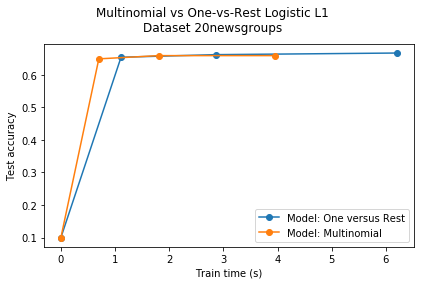

In [109]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

print(__doc__)
# Author: Arthur Mensch

t0 = time.clock()

# We use SAGA solver
solver = 'saga'

# Turn down for faster run time
n_samples = 10000

# Memorized fetch_rcv1 for faster access
#dataset = fetch_20newsgroups_vectorized('all')
#X = dataset.data
#y = dataset.target
#X = X[:n_samples]
#y = y[:n_samples]

#X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    #random_state=42,
                                                    #stratify=y,
                                                    #test_size=0.1)
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]

print('Dataset 20newsgroup, train_samples=%i, n_features=%i, n_classes=%i'
      % (train_samples, n_features, n_classes))

models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3, 7]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    # Small number of epochs for fast runtime
    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty='l1',
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % '20newsgroups')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

This was an experiment to see if LR would work better with different multiclass settings. OVR was still the better of the two types. 

Moving forward we will look to run policy types we scrape from client websites through the model we chose. Logistic Regression will more then likely be the model of choice because of the accuracy of the model the speed it complete the task. Random Forest would also be considered but accuracy would need to improve and consideration would need to be made when speed of completion is deemed important.  